In [1]:
import cv2
import pytesseract
import os
import re
import numpy as np
import tensorflow as tf
import shutil
from shutil import copyfile

In [2]:
source_path = 'foto_dataset'

source_path_struk = os.path.join(source_path, 'struk')
source_path_nostruk = os.path.join(source_path, 'nostruk')

!find /tmp/PetImages/ -type f ! -name "*.png" -exec rm {} +

print(f"There are {len(os.listdir(source_path))}")

There are 2


FIND: Invalid switch


In [3]:
import shutil
from shutil import copyfile

In [4]:
root_dir = 'train_test_val'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):

    os.makedirs(os.path.join(f'{root_path}/training', 'struk'))
    os.makedirs(os.path.join(f'{root_path}/validation', 'struk'))
    os.makedirs(os.path.join(f'{root_path}/training', 'bukan_struk'))
    os.makedirs(os.path.join(f'{root_path}/validation', 'bukan_struk'))
    
try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [5]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

train_test_val\training
train_test_val\validation
train_test_val\training\bukan_struk
train_test_val\training\struk
train_test_val\validation\bukan_struk
train_test_val\validation\struk


In [6]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

    training_number = int(len(shuffled_source) * SPLIT_SIZE)

    i = 0
    target = TRAINING_DIR

    for item in shuffled_source:
        item_source = os.path.join(SOURCE_DIR, item)
        if os.path.getsize(item_source) == 0:
            print(f'{item} is zero length, so ignoring.')
        else: 
            copyfile(item_source, os.path.join(target, item))
            i += 1

        if i == training_number:
            target = VALIDATION_DIR

In [7]:
import random

In [8]:
TRAINING_DIR = "train_test_val/training/"
VALIDATION_DIR = "train_test_val/validation/"

TRAINING_STRUK_DIR = os.path.join(TRAINING_DIR, "struk/")
VALIDATION_STRUK_DIR = os.path.join(VALIDATION_DIR, "struk/")

TRAINING_NOSTRUK_DIR = os.path.join(TRAINING_DIR, "bukan_struk/")
VALIDATION_NOSTRUK_DIR = os.path.join(VALIDATION_DIR, "bukan_struk/")

if len(os.listdir(TRAINING_STRUK_DIR)) > 0:
    for file in os.scandir(TRAINING_STRUK_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_STRUK_DIR)) > 0:
    for file in os.scandir(VALIDATION_STRUK_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_NOSTRUK_DIR)) > 0:
    for file in os.scandir(TRAINING_NONSTRUK_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_NOSTRUK_DIR)) > 0:
    for file in os.scandir(VALIDATION_NONSTRUK_DIR):
        os.remove(file.path)

split_size = .8

split_data(source_path_struk, TRAINING_STRUK_DIR, VALIDATION_STRUK_DIR, split_size)
split_data(source_path_nostruk, TRAINING_NOSTRUK_DIR, VALIDATION_NOSTRUK_DIR, split_size)

print(f"Original directory has {len(os.listdir(source_path_struk))} images")
print(f"Original directory has {len(os.listdir(source_path_nostruk))} non struk images")

print(f"There are {len(os.listdir(TRAINING_STRUK_DIR))} images for training")
print(f"There are {len(os.listdir(VALIDATION_STRUK_DIR))} images for validation")
print(f"There are {len(os.listdir(TRAINING_NOSTRUK_DIR))} non struk images for training")
print(f"There are {len(os.listdir(VALIDATION_NOSTRUK_DIR))} non struk images for validation")

Original directory has 800 images
Original directory has 800 non struk images
There are 640 images for training
There are 160 images for validation
There are 640 non struk images for training
There are 160 non struk images for validation


In [9]:
train_count_struk = len(os.listdir(TRAINING_STRUK_DIR))
val_count_struk = len(os.listdir(VALIDATION_STRUK_DIR))
train_count_nostruk = len(os.listdir(TRAINING_NOSTRUK_DIR))
val_count_nostruk = len(os.listdir(VALIDATION_NOSTRUK_DIR))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=45,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    validation_datagen = ImageDataGenerator(rescale = 1./255.)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=5,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

    return train_generator, validation_generator

In [12]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [13]:
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

def create_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation='relu'), 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

In [14]:
model = create_model()

In [15]:
history = model.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/25
29/29 [==============================] - 45s 1s/step - loss: 0.9170 - accuracy: 0.6375 - val_loss: 0.1269 - val_accuracy: 0.9594
Epoch 2/25
29/29 [==============================] - 33s 1s/step - loss: 0.2053 - accuracy: 0.9328 - val_loss: 0.0841 - val_accuracy: 0.9656
Epoch 3/25
29/29 [==============================] - 33s 1s/step - loss: 0.1318 - accuracy: 0.9555 - val_loss: 0.0399 - val_accuracy: 0.9844
Epoch 4/25
29/29 [==============================] - 32s 1s/step - loss: 0.2277 - accuracy: 0.9555 - val_loss: 0.0651 - val_accuracy: 0.9750
Epoch 5/25
29/29 [==============================] - 32s 1s/step - loss: 0.0873 - accuracy: 0.9734 - val_loss: 0.0265 - val_accuracy: 0.9844
Epoch 6/25
29/29 [==============================] - 32s 1s/step - loss: 0.1251 - accuracy: 0.9703 - val_loss: 0.0121 - val_accuracy: 0.9937
Epoch 7/25
29/29 [==============================] - 33s 1s/step - loss: 0.0742 - accuracy: 0.9797 - val_loss: 0.0220 - val_accuracy: 0.9906
Epoch 8/25
29/29 [==

In [16]:
import matplotlib.pyplot as plt

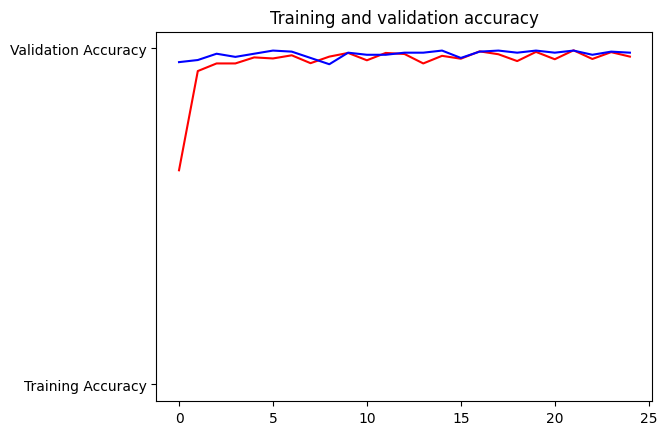

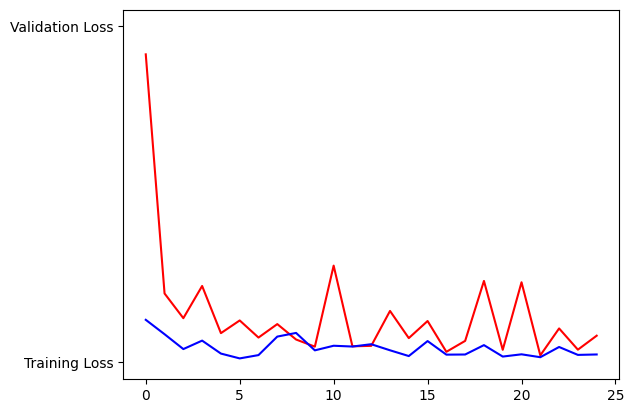

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [18]:
from PIL import Image

In [19]:
image = Image.open('ujicoba.png')
images = image
image = image.convert('RGB')

In [20]:
image = image.resize((150, 150)) 

In [21]:
image_array = np.array(image)

In [22]:
input_data = image_array / 255.0

In [23]:
input_data = np.expand_dims(input_data, axis=0)

In [24]:
predictions = model.predict(input_data)

1/1 [==============================] - 0s 313ms/step


In [25]:
class_0_probability = predictions[0][0]

print('Probability struk:', class_0_probability)

Probability struk: 1.0


In [26]:
if class_0_probability < 0.6 :
    image = None
    image_array = None
    input_data = None
    predictions = None
    class_0_probability = None

In [27]:
# text = pytesseract.image_to_string(image)

In [28]:
import easyocr

In [29]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [30]:
result = reader.readtext(images)

In [31]:
prediction = pipeline.recognize([images])

NameError: name 'pipeline' is not defined

In [49]:
valid = []
pattern = r'^[\d.,]+$'

for detection in result:
    text = detection[1]
    match = re.search(pattern, text)
    if match:
        valid.append(text)
        print(text)

17435
13500
13,500
6500
33,000
33,000
6,500


In [50]:
valid = [x for x in valid if not x.startswith('0')]

In [51]:
import locale

In [52]:
def remove_comma_dot_zero(value):
    value = value.replace(',', '')
    value = value.replace('.', '')
    value = value.lstrip('0')
    return value


In [53]:
nilai_terubah = []
for n in valid:
    n = remove_comma_dot_zero(n)
    nilai_terubah.append(int(n))

In [54]:
nilai_terubah

[17435, 13500, 13500, 6500, 33000, 33000, 6500]

In [55]:
true_value = max(nilai_terubah)
true_value

33000